In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time   

In [2]:
control_space_size = 3

U_space_1 = np.array(np.linspace((-1),(1),control_space_size))
U_space_2 = np.array(np.linspace((-1),(1),control_space_size))
time_step = 0.033

In [3]:
time_step = 0.033

#weights = np.array([-3.00613544e+01,-1.35285679e+01,-3.16906745e+01,-3.42397218e+01,-1.82064449e+01,-9.78983289e-01,-3.14145396e-01,2.16345019e-01,-1.99320125e+01,3.33850141e-01,1.98431644e-02,-3.61292790e-01])
#weights = np.array([-13.82806378,-7.37552209,-19.5130216,-16.57098794,-6.44948079,-0.56244083, 0.08046996,-0.72077351,-12.43774902,-0.02072203,0.07882772,0.7128548])
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    
    return(poses)


def lb_ub_support(mu,cov):
    
    # Calculate the lower and upper bounds with 95% confidence
    z = st.norm.ppf(0.975) 
    lower_bound = mu - z * np.diag(np.linalg.cholesky(cov))
    upper_bound = mu + z * np.diag(np.linalg.cholesky(cov))
    
    return(lower_bound,upper_bound)

def q_constant(lower_bound,upper_bound):
    length = np.array(upper_bound-lower_bound)

    area = np.product(length)
    
    q_constant = 1/area
    
    return(q_constant)

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

import numpy as np

def multivariate_rbf_kernel(X1, X2, gamma):
    #Compute the multivariate Radial Basis Function (RBF) kernel between two sets of input points.
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))

    diff = X1[:] - X2[:]
    K = np.exp(-gamma * np.dot(diff, diff))

    return K


def state_cost(state,goal_points,obs_points):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    #cost = 60*(state[0]-goal_points[0])**2 + 60*(state[1]-goal_points[1])**2 + 200*(np.exp(-(np.abs(state[0]-obs_points[0,0])+np.abs(state[1]-obs_points[1,0]))) + np.exp(-(np.abs(state[0]-obs_points[0,1]) + np.abs(state[1]-obs_points[1,1]))) + np.exp(-(np.abs(state[0]-obs_points[0,2])+np.abs(state[1]-obs_points[1,2])))) #actual cost
    
    #cost = 70*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + 100*(my_logpdf(state[:2],obs_points[:2,0],covar) + my_logpdf(state[:2],obs_points[:2,1],covar) + my_logpdf(state[:2],obs_points[:2,2],covar) + my_logpdf(state[:2],obs_points[:2,3],covar) + my_logpdf(state[:2],np.array([-1.7,-1]),covar) + my_logpdf(state[:2],np.array([1.7,1]),covar))
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        #gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
        #gauss_sum += -weights[:,i+1]*multivariate_rbf_kernel(state[:2],obs_points[:2,i],20)
        
    #cost = -weights[:,0]*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
    #            + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
    #            + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 3.5*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    return(cost)

def C_Bar(state,goal_points):
    
    #ind = discretize(state, 2, [-np.pi, -5], [2*np.pi/50, 0.2])
    Cost = np.zeros((10,10)) #initialize cost
    #Cost = 0
    
    for i in range(10):
            for j in range(10):
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[1, 0.5, 0.3], [0.5, 1, 0.2], [0.3, 0.2, 1]])
                f = st.multivariate_normal(next_state.reshape((3,)),cov)
                next_state = f.rvs()
                cost = state_cost(next_state,goal_points)
                Cost[i,j] = cost
    
    Expected_Cost = np.sum(Cost*(1/100))
                
    return(Expected_Cost)

def c_hat(state,goal_points,obs_points):
    
    pf = np.zeros((control_space_size,control_space_size))
    for i in range(control_space_size):
        for j in range(control_space_size):
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            N_samples = 20
            next_sample = f.rvs(N_samples)

            #next_sample = np.reshape(next_sample,(2,N_samples))

            cost=0
            for k in range(N_samples):
                cost+=state_cost(next_sample[k,:],goal_points,obs_points)

            log_DKL = np.exp(-(-f.entropy())-cost/N_samples)
            pf[i,j] = log_DKL
    pf_sum = np.sum(pf)
    
    cost_hat = np.log(pf_sum)
    
    return(cost_hat)

    
def Control_step(state,U_space_1,U_space_2,goal_points):
    ###
    #target_pf = 1/control_space_size**2
    time_step = 0.033
    A = np.array([[1, 0],
              [0, 1]])

    B = np.array([[1, 0],
              [0, 1]])
    
    mu = np.zeros(5)
    Sigma = 0.003 * np.eye(5)
    np.random.seed(0)

    x_r = np.array([goal_points[0], goal_points[1]])
    Sigma_r = 0.001 * np.eye(2)
    u_d = 0
    Sigma_u = 0.07 * np.eye(2)
    W = np.eye(2)*8.6
    
    # controller parameters
    Q = np.linalg.inv(np.linalg.inv(Sigma_u) + B.T @ (np.linalg.inv(Sigma_r)+W) @ B)
    L = Q @ B.T @ (np.linalg.inv(Sigma_r)+W) @ A
    X_r = Q @ B.T @ (np.linalg.inv(Sigma_r)+W) @ x_r
    
    
    mean = np.reshape(-L@ state + X_r.reshape((2,1)),(2,))


    u_norm = st.multivariate_normal(mean,Q)

    action = np.reshape(u_norm.rvs(),(2,1))
    
    return(action)

In [7]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

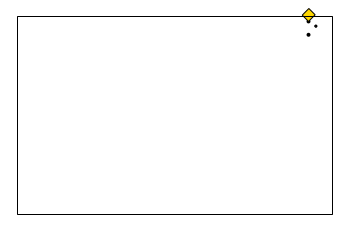

##### DEBUG OUTPUT #####
Your simulation will take approximately 18 real seconds when deployed on the Robotarium. 

	 Simulation had 2537 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

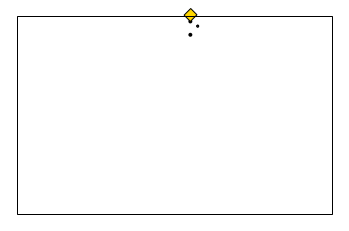

##### DEBUG OUTPUT #####
Your simulation will take approximately 13 real seconds when deployed on the Robotarium. 

	 Simulation had 2853 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

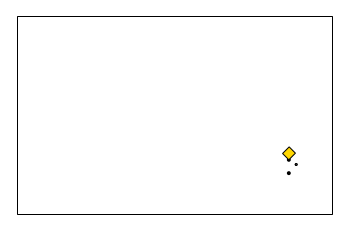

##### DEBUG OUTPUT #####
Your simulation will take approximately 14 real seconds when deployed on the Robotarium. 

	 Simulation had 3206 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

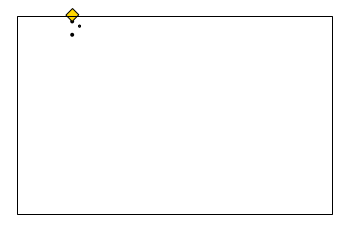

##### DEBUG OUTPUT #####
Your simulation will take approximately 9 real seconds when deployed on the Robotarium. 

	 Simulation had 3440 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

In [9]:
goal_points = np.array(np.mat('-1.40; -0.8; 0'))

# obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))

# obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

    
# Instantiate Robotarium object
N = 1
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1.0;0.9; 0'))]
# initial_conditions = [np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.8; 0')),np.array(np.mat('-1.4;0.9; 0'))]
#initial_conditions = [np.array(np.mat('-1;0.9; 0'))]
X_Si = [0]*4
D_Xi = [0]*4

for I in range(4):
    
    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    #obs_points = np.array(np.mat('0 0 0 0 0 0.9 -0.8 -0.8;0 0.2 0.4 0.6 0.8 -0.7 -0.9 -0.8;0 0 0 0 0 0 0 0'))

    # Create single integrator position controller
    single_integrator_position_controller = create_si_position_controller()

    # Create barrier certificates to avoid collision
    #si_barrier_cert = create_single_integrator_barrier_certificate()
    si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

    _, uni_to_si_states = create_si_to_uni_mapping()

    # Create mapping from single integrator velocity commands to unicycle velocity commands
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)
    
    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.1
    obs_marker_size_m = 0.1
    #robot_marker_size_m = 0.1
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    #marker_size_robot = determine_marker_size(r, robot_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]
    #robot_markers = [r.axes.scatter(x[0,ii], x[1,ii], s=marker_size_robot, marker='o', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width) 
    #for ii in range(goal_points.shape[1])]

    # #Text with goal identification
    # obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    # #Plot text for caption
    # obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    # for ii in range(obs_points.shape[1])]
    # obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    # for ii in range(obs_points.shape[1])]

    r.step()
    
        # While the number of robots at the required poses is less
    # than N...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)
        #print(x_si.shape)
        X_si.append(x_si)
        
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs()
        
        #Update Plot
        # Update Robot Marker Plotted Visualization
        #for i in range(x.shape[1]):
            #robot_markers[i].set_offsets(x[:2,i].T)
            # This updates the marker sizes if the figure window size is changed. 
            # This should be removed when submitting to the Robotarium.
            #robot_markers[i].set_sizes([determine_marker_size(r, robot_marker_size_m)])

        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])
        
        # for j in range(obs_points.shape[1]):
        #     obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Create single-integrator control inputs
        #dxi = single_integrator_position_controller(x_si, goal_points[:2][:])
        dxi = Control_step(x_sample.reshape((2,1)),U_space_1,U_space_2,goal_points)
        D_xi.append(dxi)
        #print(dxi)

        # Create safe control inputs (i.e., no collisions)
        #dxi = si_barrier_cert(dxi, x_si)

        # Transform single integrator velocity commands to unicycle
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities by mapping the single-integrator inputs to unciycle inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        
    D_Xi[I] = D_xi
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()
    
#D_Xi = np.array(D_Xi,dtype=o
#X_Si = np.array(X_Si,dtype=object)

np.save('State_Data_Simulation_Cont.npy',X_Si)
np.save('Input_Data_Simulation_Cont.npy',D_Xi)


In [13]:
XX = np.load('State_Data_Simulation_Cont.npy',allow_pickle=True)
UU = np.load('Input_Data_Simulation_Cont.npy',allow_pickle=True)

In [14]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [15]:
# Defining the the feature points on the robotarium grid
# obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

goal_points = np.array(np.mat('0 0 0 0 0 1.4 1.4 1.4 1.4 1.4 -1.4 -1.4 -1.4 -1.4 -1.4;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [16]:
N_feature = np.size(goal_points,axis=1)
print(N_feature)

15


In [17]:
# Defining feature vector h()

def feature(next_state,goal_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(goal_points,axis=1)):
        features[i] = (((next_state[0]-goal_points[0][i])**2 + (next_state[1]-goal_points[1][i])**2))
    
    return features

In [ ]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time

# N_feature = 2
M = np.size(X,axis=1) - 1
w = cp.Variable((1,N_feature))

#v = cp.Variable((2,2))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []
#S_axis = np.array([i for i in range(51)])

f_expect = np.zeros((2,20)) 
#features = np.zeros((2,10,10)) 
# feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((M,10))
#pf = np.zeros((10,10))
#Log_DKL = np.zeros((20,M))

q_u = st.uniform(loc=-5,scale=10)
features = np.zeros((N_feature,10,M))
feature_sampled = np.zeros((N_feature,M))
#features2 = np.zeros((N_feature,10,M))

feature_sampled_mean = np.zeros((N_feature,M))

for i in range(M):

    #############################################################################################################################
    
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033
    
    qu_sample = q_u.rvs((2,10))    
    pf = np.zeros((10,)) #Initialize pf
    
    for j in range(10):
        next_state = model_step(state,[qu_sample[0,j],qu_sample[1,j]],time_step)
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        f = st.multivariate_normal(next_state.reshape((2,)),cov)
        next_sample = f.mean
            
        N_samples = 5
        next_samples = f.rvs(N_samples)
        feature_sample = np.zeros((N_feature,N_samples))
        
        for m in range(N_samples):
            feature_sample[:,m] = feature(next_samples[m,:],goal_points,N_feature)
        
        features[:,j,i] = np.mean(feature_sample,axis=1)
        
        #Calculate the DKL for each possible input, get corresponding probability
        log_DKL = f.entropy()
        # log_DKL = calculate_kl_divergence(next_state.mean,Sigma,np.zeros((5,)),Sigma_r)
        pf[j] = 0.1*log_DKL 
    PF[i,:] = pf
    
    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,N_feature)
    
    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)    
        
    
    #Log likelihood for each instance
    # L.append(-(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size**2,)) + cp.log(np.reshape(PF[:,:,i],(control_space_size**2,)))))
    
    L.append(-(w @ feature_sampled_mean[:,i]) + cp.log_sum_exp((cp.reshape(w @ features[:,:,i],(10,)) + PF[i,:])))

objective = cp.Minimize(cp.sum(L))    
    
prob = cp.Problem(objective,w<=0)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [18]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
#v = cp.Variable((2,2))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []
#S_axis = np.array([i for i in range(51)])

f_expect = np.zeros((2,20)) 
#features = np.zeros((2,10,10)) 
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))
#pf = np.zeros((10,10))
#Log_DKL = np.zeros((20,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033
    
        
    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    
    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.01, 0.002], [0.002, 0.01]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean
            
            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))
            
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,N_feature)
            
            features[:,j,k] = np.mean(feature_sample,axis=1)
            # features[:,j,k] = feature(next_sample,goal_points,N_feature)
            
            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL 
    PF[:,:,i] = pf
    
    features = np.reshape(features,(N_feature,control_space_size**2))
    
    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.01, 0.002], [0.002, 0.01]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,N_feature)
    
    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    # feature_sampled[:,i] = feature(f1.mean,goal_points,N_feature)
    
    #Log likelihood for each instance
    L.append(-(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size**2,)) + cp.log(np.reshape(PF[:,:,i],(control_space_size**2,))))) 

objective = cp.Minimize(cp.sum(L))    
constraints = [w<=0]    
prob = cp.Problem(objective,constraints)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [19]:
weights = w.value

#np.save('Weights.npy',weights)

print('weights:',weights)

weights: [[-0.34712664 -0.37723033 -0.29258903 -0.24498976 -0.1110082  -0.09874818
  -0.16668695 -0.06846851 -0.05951762 -0.06409885 -8.09183147 -0.08400728
  -0.15978023 -0.11903051 -0.13435098]]


In [1006]:
np.save('Weights_Cont.npy',weights)

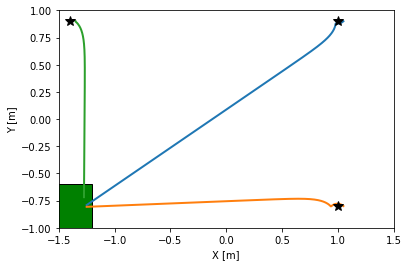

In [1019]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)
# plt.plot(X_plot[3][:,0],X_plot[3][:,1],linewidth=2)

# plt.plot(X_p_mean[:,0],X_p_mean[:,1],linewidth=1.0)
# plt.plot(X_p_mean[:,0]-X_p_std[:,0],X_p_mean[:,1]-X_p_std[:,1],linewidth=0.000001,color='blue')
# plt.plot(X_p_mean[:,0]+X_p_std[:,0],X_p_mean[:,1]+X_p_std[:,1],linewidth=0.000001,color='blue')

plt.plot(1.0,0.9,'*',color='black',markersize=10)
plt.plot(1.0,-0.8,'*',color='black',markersize=10)
plt.plot(-1.4,0.9,'*',color='black',markersize=10)
# plt.plot(-1,0.9,'*',color='black',markersize=10)

#plt.axes()
square1 = plt.Rectangle((-1.6,-1.0), 0.4, 0.4, fc='green',ec="black")
# square3 = plt.Rectangle((-0.9,-1), 0.4, 0.4, fc='red',ec="black")
# square2 = plt.Rectangle((-0.2,0), 0.4, 1, fc='red',ec="black")
# plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
# plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
# plt.show()
plt.savefig('Test_robot_Trajectories_Cont.jpg',dpi=1000,bbox_inches ='tight')
# plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

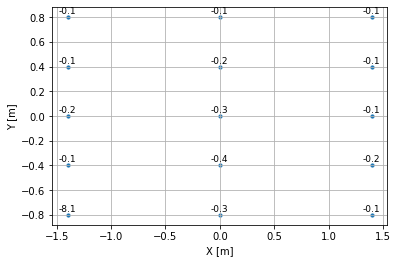

In [20]:
# Plotting feature points on the robotarium grid with correspopnding weights

import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.scatter(goal_points[0,:],goal_points[1,:],s=10)

w = np.zeros((15,))

for j in range(15):
    wt = float(weights[:,j])
    w[j] = round(wt,1)

for i, txt in enumerate(w.reshape(15,)):
    ax.annotate(txt,(goal_points[0,i],goal_points[1,i]), fontsize=9, xytext=(-9, 3.5), textcoords='offset points')

plt.grid(True)

plt.xlabel('X [m]')
plt.ylabel('Y [m]')

plt.savefig('weighted_feature_point_grid.jpg',dpi=1000,bbox_inches ='tight')
# plt.show()

In [21]:
# formulating the reconstructed cost map

import numpy as np 
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))


def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost_estimated(state,goal_points,weights):
    #weights = np.reshape(weights,(9,))
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    cost_sum = 0
    
    for i in range(np.size(goal_points,axis=1)):
        cost_sum += -weights[:,i]*((((state[0]-goal_points[0][i])**2 + (state[1]-goal_points[1][i])**2)))
        #gauss_sum += -weights[:,i+1]*multivariate_rbf_kernel(state[:2],obs_points[:2,i],50)
        # gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)
    
    cost =  cost_sum
    #cost = 4.16*np.sqrt((ind[0]-25)**2)+2.44*np.sqrt((ind[1]-25)**2) #estimated cost
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):
        
        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,weights)

C:\Users\jamal\AppData\Local\Temp\ipykernel_27720\1973027062.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
C:\Users\jamal\AppData\Local\Temp\ipykernel_27720\1973027062.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


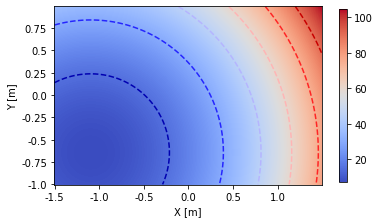

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_title('Rotated Heatmap')

ax.invert_yaxis()

# Define the desired tick positions and labels for x and y axes
x_ticklabels = np.arange(-2, 2, 0.5)  # Example: custom tick labels for x-axis
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  # Example: custom tick labels for y-axis

# Set the x and y axis tick positions and labels
ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

# Display the plot
# plt.show()
plt.savefig('Est_Cost_Heat_Map_Cont.jpg',dpi=1000,bbox_inches ='tight')

In [1003]:
# formulating the reconstructed cost map

import numpy as np 
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))


def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost_estimated(state,goal_points,weights):
    #weights = np.reshape(weights,(9,))
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    cost_sum = 0
    
    for i in range(np.size(goal_points,axis=1)):
        cost_sum += 0.5*((((state[0]-goal_points[0][i])**2 + (state[1]-goal_points[1][i])**2)))
        #gauss_sum += -weights[:,i+1]*multivariate_rbf_kernel(state[:2],obs_points[:2,i],50)
        # gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)
        
    # cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum - weights[:,-1] *(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    #             + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    #             + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    cost =  cost_sum
    #cost = 4.16*np.sqrt((ind[0]-25)**2)+2.44*np.sqrt((ind[1]-25)**2) #estimated cost
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):
        
        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,weights)

C:\Users\jamal\AppData\Local\Temp\ipykernel_16472\1800790867.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
C:\Users\jamal\AppData\Local\Temp\ipykernel_16472\1800790867.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


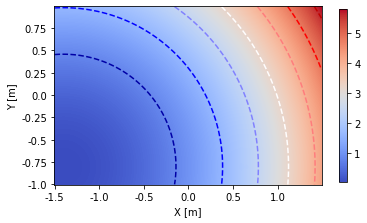

In [1004]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_title('Rotated Heatmap')

ax.invert_yaxis()

# Define the desired tick positions and labels for x and y axes
x_ticklabels = np.arange(-2, 2, 0.5)  # Example: custom tick labels for x-axis
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  # Example: custom tick labels for y-axis

# Set the x and y axis tick positions and labels
ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

# Display the plot
# plt.show()
plt.savefig('OG_Cost_Heat_Map_Cont.jpg',dpi=1000,bbox_inches ='tight')